In [1]:
import pandas as pd 
import os
import numpy as np
import sys 
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import tensorflow as tf
import random
import torch
import torchvision
from math import sqrt

2024-03-31 20:46:04.237695: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-31 20:46:04.273844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 20:46:05.286415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data1 =pd.read_csv('.../data1.csv')
data9 = pd.read_csv('.../data_1_test.csv')

df_1 = data1.iloc[:, 1:]
df_9 = data9.iloc[:,1:]

df_1 = pd.merge(df_1, df_9[['Folder', 'internal_vdw_energy']], on='Folder', how='inner')

columns = df_1.columns.tolist()

columns.remove("Folder")
columns.remove("QM/MM SP Barrier")

new_columns_order = columns + ["Folder", "QM/MM SP Barrier"]

# Reindex the DataFrame to reorder the 
df_1 = df_1.reindex(columns=new_columns_order)
df_1.head()

661  666  156  444  705  407  807  650  356  699  ...    Box_26  Box_33  \
0    0    0    1    1    0    0    1    1    2    0  ... -0.241552     0.0   
1    0    0    0    0    0    1    0    0    5    0  ...  0.000000     0.0   
2    0    0    0    0    0    0    1    2    4    0  ... -1.176918     0.0   
3    0    0    0    0    0    1    1    1    2    0  ...  0.096336     0.0   
4    1    0    0    0    0    0    1    1    3    1  ...  0.026424     0.0   

   Box_34    Box_46    Box_50    Box_51  Total Charge  internal_vdw_energy  \
0     0.0  0.000000 -0.758976 -1.007604      1.000009             2.925351   
1     0.0 -0.056827 -0.020914 -0.183128     -0.000017            -4.432160   
2     0.0 -0.249862 -0.349354  0.000000      0.000008            -5.104365   
3     0.0  0.000000 -0.883456  0.819872     -0.000009            -3.150597   
4     0.0  0.000000  0.662524 -1.430314      0.999997            -2.510429   

       Folder  QM/MM SP Barrier  
0  mol_134810             29.71  
1  mol_147462             28.33  
2   mol_22419             28.28  
3     mol_469             22.72  
4   mol_67286             25.81  

[5 rows x 739 columns]

## Data Loading

data_all.iloc[:,-2]

In [3]:
data_all = pd.read_csv('data.csv')
data_all=data_all.iloc[:,1:]
data_all.head()

343  94  705  291  nBonds  312  298  261  221  resid 146  ...  825  309  \
0    0   0    0    0      23    0    0    0    0  22.125732  ...    0    0   
1    0   0    0    0      26    0    0    0    0  23.807538  ...    0    0   
2    0   0    0    0      27    0    0    0    0  18.458300  ...    0    0   
3    0   0    0    0      27    0    0    0    0  23.710574  ...    0    0   
4    0   0    0    0      24    0    0    0    0  21.308187  ...    0    0   

   262  826  266  276  310  757      Folder  QM/MM SP Barrier  
0    0    0    0    0    0    0  mol_134810             29.71  
1    0    0    0    0    0    0  mol_147462             28.33  
2    0    0    0    0    0    0  mol_152261             27.40  
3    0    0    0    0    0    0   mol_22419             28.28  
4    0    0    0    0    0    0     mol_469             22.72  

[5 rows x 184 columns]

In [4]:
# Number of training sets
n=6

all_data_y = df_1.iloc[:,-2].values

In [5]:
def split_data(df, total_sets=10, training_sets=5):
    # Set Size
    set_size = len(df) // total_sets
    
    df['set'] = df.index // set_size
    df.loc[df['set'] >= total_sets, 'set'] = total_sets - 1  
    
    training_df = pd.DataFrame()
    testing_df = pd.DataFrame()
    
    # Split the data
    for set_number in range(total_sets):
        set_df = df[df['set'] == set_number]
        if set_number < training_sets:
            training_df = pd.concat([training_df, set_df])
        else:
            testing_df = pd.concat([testing_df, set_df])
    
    # Drop the 'set' column
    training_df = training_df.drop(columns=['set'])
    testing_df = testing_df.drop(columns=['set'])
    
    return training_df, testing_df

training_df, testing_df = split_data(df_1, total_sets=11, training_sets=n)

print("Training data size:", len(training_df))
print("Testing data size:", len(testing_df))


Training data size: 4668
Testing data size: 3890


## Pre-process

In [ ]:
train_x = training_df.iloc[:,:-2].values
train_y = training_df.iloc[:,-1].values

test_x = testing_df.iloc[:, :-2].values
test_y = testing_df.iloc[:, -1].values

#### for data1

In [8]:
import torch
from sklearn.preprocessing import StandardScaler


# Convert NumPy arrays to Torch tensors
train_x_torch = torch.tensor(train_x, dtype=torch.float32)
train_y_torch = torch.tensor(train_y, dtype=torch.float32)
test_x_torch = torch.tensor(test_x, dtype=torch.float32)
test_y_torch = torch.tensor(test_y, dtype=torch.float32)

# Initialize the StandardScaler
ss = StandardScaler()

# Reshape the data to a 2D array with one column
train_y_reshaped_t = train_y_torch.view(-1, 1)
test_y_reshaped_t = test_y_torch.view(-1, 1)

# Transform the target data
train_out_np = ss.fit_transform(train_y_reshaped_t.numpy())
test_out_np = ss.fit_transform(test_y_reshaped_t.numpy())

# Convert the NumPy arrays to Torch tensors
train_out_t = torch.from_numpy(train_out_np)
test_out_t = torch.from_numpy(test_out_np)


### Normalisation

In [9]:


from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

train_y_reshaped = train_y.reshape(-1, 1)
test_y_reshaped = test_y.reshape(-1, 1)
#val_y_reshaped = val_y.reshape(-1, 1)


train_out = ss.fit_transform(train_y_reshaped)
test_out = ss.fit_transform(test_y_reshaped)
print(train_out)

[[ 0.67947992]
 [ 0.00299396]
 [-0.0215164 ]
 ...
 [-0.75682723]
 [ 0.44418046]
 [-0.75192516]]


`Low-RandomForest` PyTorch Implementation

In [10]:

from random_forest_torch import TorchRandomForestRegressor, TorchDecisionTreeRegressor, DecisionNode
rf2 = TorchRandomForestRegressor(nb_trees=8, nb_samples=40, max_depth=200, bootstrap=True)
rf2.fit(train_x_torch,train_out_t)

Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Value: 0.0, Gain: 0.8577891230583192
Col: 0, Va

Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Value: 0.0, Gain: 0.8577891230583192
Col: 4, Va

In [11]:

pred_low_rf = [rf2.predict(torch.FloatTensor(test_vector)) for test_vector in test_x_torch]


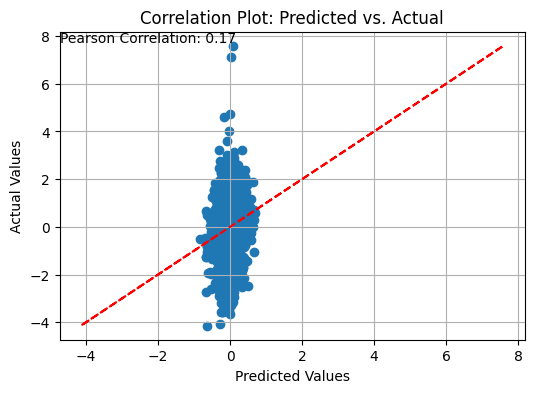

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

pred_low_rf_np = np.array([pred.numpy() for pred in pred_low_rf])

test_out_np = test_out_t.numpy()

# Plot the predicted values against the actual values
plt.figure(figsize=(6, 4))
plt.scatter(pred_low_rf_np, test_out_np)
plt.plot(test_out_np, test_out_np, color='red', linestyle='--')  # Plot y=y line for reference

# Calculate the Pearson correlation coefficient
pearson_corr, _ = pearsonr(pred_low_rf_np.ravel(), test_out_np.ravel())

# Display the Pearson correlation coefficient
plt.text(plt.xlim()[0], plt.ylim()[1], f'Pearson Correlation: {pearson_corr:.2f}', va='top', ha='left')

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Correlation Plot: Predicted vs. Actual')
plt.grid(True)
plt.show()


`RandomForest`

In [13]:
rf = RandomForestRegressor(
    n_estimators=160,
    criterion="squared_error",
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.8,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=40,
    ccp_alpha=0.00,
    max_samples=None,
    monotonic_cst=None)

rf.fit(train_x,train_out)
pred_sklrn = rf.predict(test_x)

/home/juan/myenv/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


## Analysis

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predictions from both models (standarized)
pred_low_rf_flattened = np.concatenate(pred_low_rf)

pred_low_rf_np = np.array(pred_low_rf_flattened)

# Actual values (standarized)
actual_values = test_out

pred_low_rf_np_reshaped = pred_low_rf_np.reshape(-1, 1)
pred_rf_reshaped = pred_sklrn.reshape(-1, 1)
pred_low_rf_unstd = ss.inverse_transform(pred_low_rf_np_reshaped).flatten()
pred_rf_unstd = ss.inverse_transform(pred_rf_reshaped).flatten()

# Unstandardizing the actual values
actual_values_reshaped = actual_values.reshape(-1, 1)
actual_values_unstd = ss.inverse_transform(actual_values_reshaped)

#### Top 10% predictions

#### Lowest Values

In [15]:
# Threshold for the lowest 10% of predictions
threshold_low_rf = np.percentile(pred_low_rf_unstd, 10)

# Identify the indices of the predictions that are in the lowest 10%
indices_low_rf_bottom_10 = np.where(pred_low_rf_unstd <= threshold_low_rf)[0]

# Threshold for the lowest 10% of predictions
threshold_rf = np.percentile(pred_rf_unstd, 10)

# Identify the indices of the predictions that are in the lowest 10%
indices_rf_bottom_10 = np.where(pred_rf_unstd <= threshold_rf)[0]

# Extract actual values for the lowest 10% predictions from each model
actual_values_low_rf_bottom_10 = actual_values_unstd.flatten()[indices_low_rf_bottom_10]
actual_values_rf_bottom_10 = actual_values_unstd.flatten()[indices_rf_bottom_10]


In [16]:
low_pred=pred_rf_unstd[indices_rf_bottom_10]

0.39308569654663345


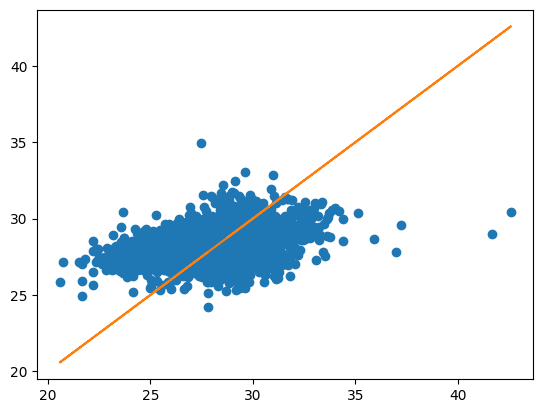

In [17]:
plt.plot(test_y, pred_rf_unstd,'o')
plt.plot(test_y,test_y)
print(pearsonr(test_y, pred_rf_unstd)[0])

In [18]:
actual_values_unstd, print(f"test_y: {test_y}")

test_y: [28.75 29.1  27.42 ... 29.66 28.09 27.78]


(array([[28.75],
        [29.1 ],
        [27.42],
        ...,
        [29.66],
        [28.09],
        [27.78]]),
 None)

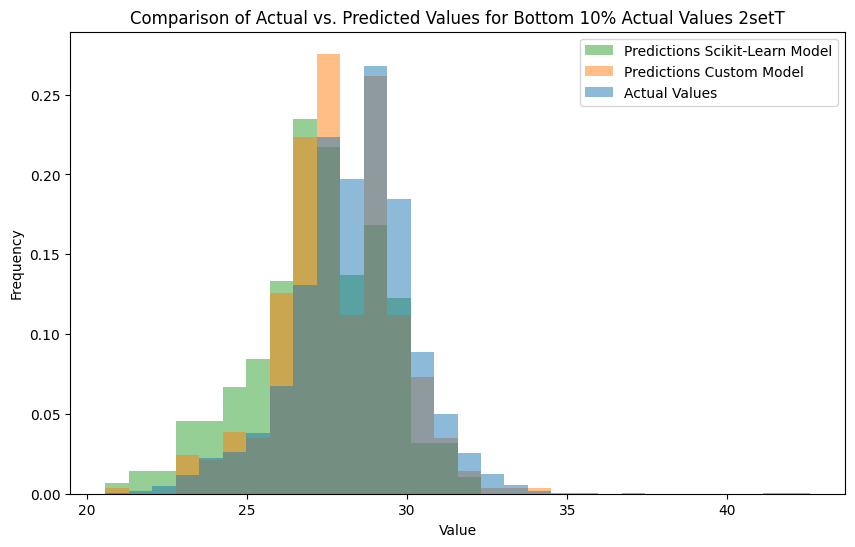

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Histogram of actual values
plt.hist([test_y,actual_values_low_rf_bottom_10,actual_values_rf_bottom_10] , histtype='stepfilled', bins=30, alpha=0.5, density = True, label=['Actual Values', 'Predictions Custom Model', 'Predictions Scikit-Learn Model'])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Comparison of Actual vs. Predicted Values for Bottom 10% Actual Values 2setT')
plt.legend()
plt.show()


In [20]:
np.mean(actual_values_rf_bottom_10)

27.23002570694087

In [21]:
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.integrate import quad

# Calculate KDE
kde = gaussian_kde(test_y, bw_method=1.5)  # Adjust bw_method as needed
kde_actual_values_low_rf = gaussian_kde(actual_values_rf_bottom_10, bw_method=1.5)

# Define the threshold 
x_max = 25.3

# Function to integrate the KDE up to x_max
def integrate_kde_up_to(kde, x_max):
    x_min = min(kde.dataset.min(), x_max)  # Adjust the minimum to be within the range
    area, _ = quad(kde, x_min, x_max)
    return area

area_test_y = integrate_kde_up_to(kde, x_max)
area_actual_values_low_rf = integrate_kde_up_to(kde_actual_values_low_rf, x_max)

# Area difference
area_difference = area_actual_values_low_rf - area_test_y

print(f"Area under the KDE curve for test_y up to {x_max}: {area_test_y}")
print(f"Area under the KDE curve for actual_values_low_rf up to {x_max}: {area_actual_values_low_rf}")
print(f"Difference in area: {area_difference}")

Area under the KDE curve for test_y up to 25.3: 0.16831256052400195
Area under the KDE curve for actual_values_low_rf up to 25.3: 0.2585911410584831
Difference in area: 0.09027858053448112


Area difference: <area_difference_value>, Area predicted: <area_actual_values_low_rf_value>


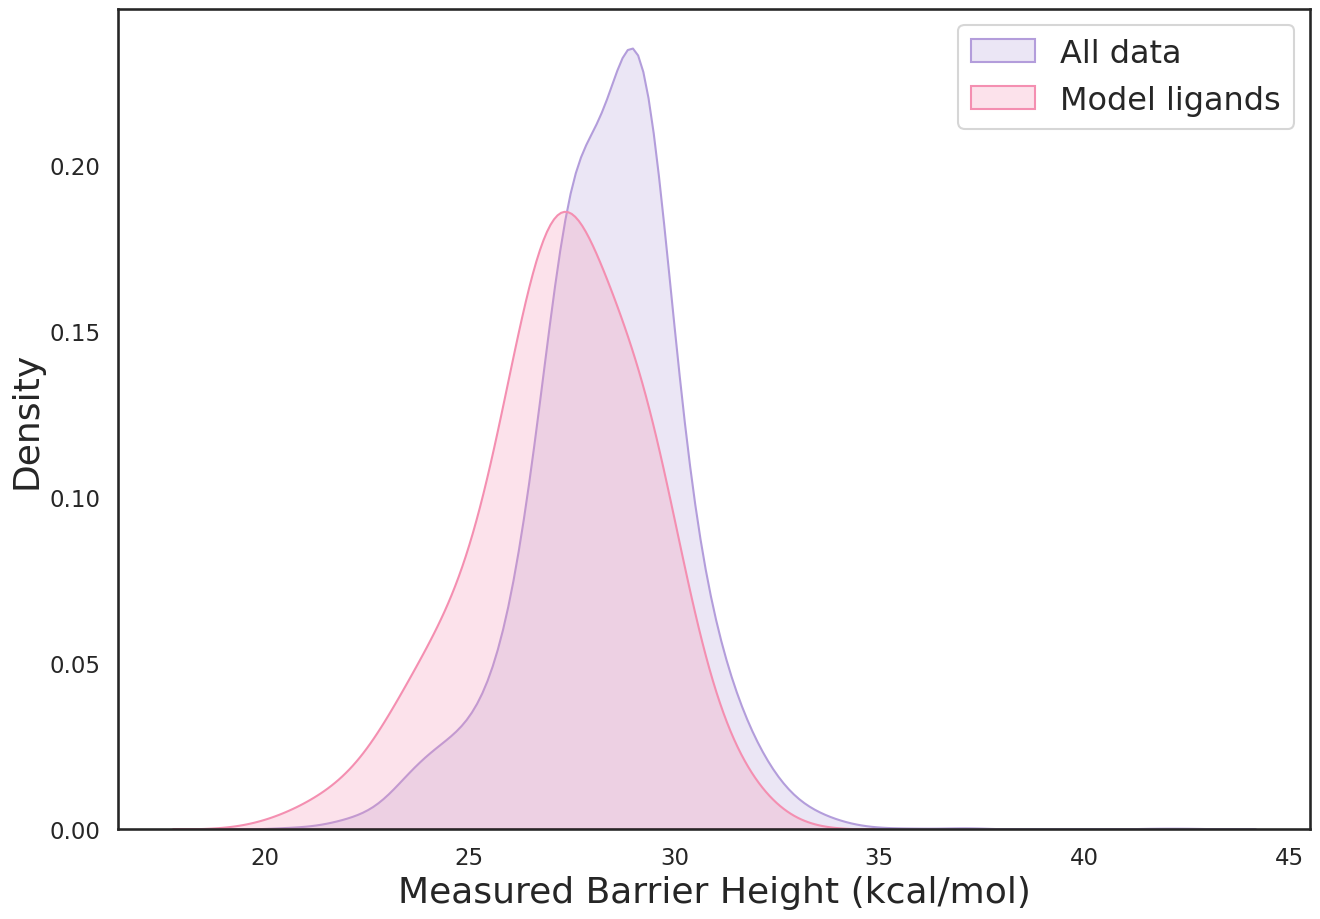

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="pastel", context="talk")

fig, ax1 = plt.subplots(figsize=(15, 11))  

pastel_purple = "#b39ddb"
pastel_pink = "#f48fb1"

# Plot KDE for actual values
sns.kdeplot(test_y, ax=ax1, label='All data', fill=True, color=pastel_purple, bw_adjust=1.5)
sns.kdeplot(actual_values_rf_bottom_10, ax=ax1, fill=True, color=pastel_pink, label='Model ligands', bw_adjust=1.5)

ax1.set_xlabel('Measured Barrier Height (kcal/mol)', fontsize=26)
ax1.set_ylabel('Density', fontsize=26)
ax1.legend(fontsize=23)
#ax1.set_title(f'KDE Normalized Frequency of barrier data vs Model Selections', fontsize=27, pad=20)

plt.tight_layout(pad=4.0)

area_difference = "<area_difference_value>"  
area_actual_values_low_rf = "<area_actual_values_low_rf_value>"
print(f"Area difference: {area_difference}, Area predicted: {area_actual_values_low_rf}")

plt.show()


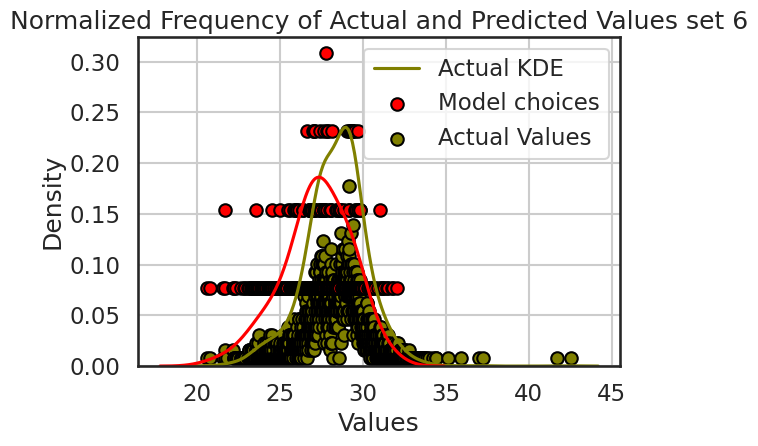

In [23]:
import seaborn as sns

unique_actual, actual_counts = np.unique(test_y, return_counts=True)
unique_predicted, predicted_counts = np.unique(actual_values_rf_bottom_10, return_counts=True)

# To normalize the plot, I'll use density instead of counts for the histogram and adjust the KDE accordingly.

fig, ax = plt.subplots()

# Plot KDE for actual values
sns.kdeplot(test_y, ax=ax, label='Actual KDE',color='olive', bw_adjust=1.5)

# Plot KDE for model's choices
sns.kdeplot(actual_values_rf_bottom_10, ax=ax,color='red', label='Model ligands KDE', bw_adjust=1.5)

# Normalize the actual counts
normalized_actual_counts = actual_counts / actual_counts.sum() * 30

# Normalize the predicted counts
normalized_predicted_counts = predicted_counts / predicted_counts.sum() * 30

ax.scatter(unique_actual, normalized_actual_counts, color='olive', edgecolor='black', label='Actual Values')

ax.scatter(unique_predicted, normalized_predicted_counts, color='red', edgecolor='black', label='Model choices')

ax.set_xlabel('Values')
ax.set_ylabel('Density')
ax.set_title(f'Normalized Frequency of Actual and Predicted Values set {n}')

handles, labels = ax.get_legend_handles_labels()
handles[1], labels[1] = handles[3], labels[3]
# Remove duplicate handles and labels
handles, labels = handles[:3], labels[:3]
ax.legend(handles, labels)

ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate MAE and RMSE for the bottom 10% predictions from both models
mae_bottom_low_rf = mean_absolute_error(actual_values_bottom_10, pred_low_rf_bottom_10)
rmse_bottom_low_rf = mean_squared_error(actual_values_bottom_10, pred_low_rf_bottom_10, squared=False)

mae_bottom_rf = mean_absolute_error(actual_values_bottom_10, pred_rf_bottom_10)
rmse_bottom_rf = mean_squared_error(actual_values_bottom_10, pred_rf_bottom_10, squared=False)
# Print MAE and RMSE for the bottom 10% predictions from both models
print("Random Forest (Low Estimators) - MAE for bottom 10% predictions:", mae_bottom_low_rf)
print("Random Forest (Low Estimators) - RMSE for bottom 10% predictions:", rmse_bottom_low_rf)

print("Random Forest - MAE for bottom 10% predictions:", mae_bottom_rf)
print("Random Forest - RMSE for bottom 10% predictions:", rmse_bottom_rf)


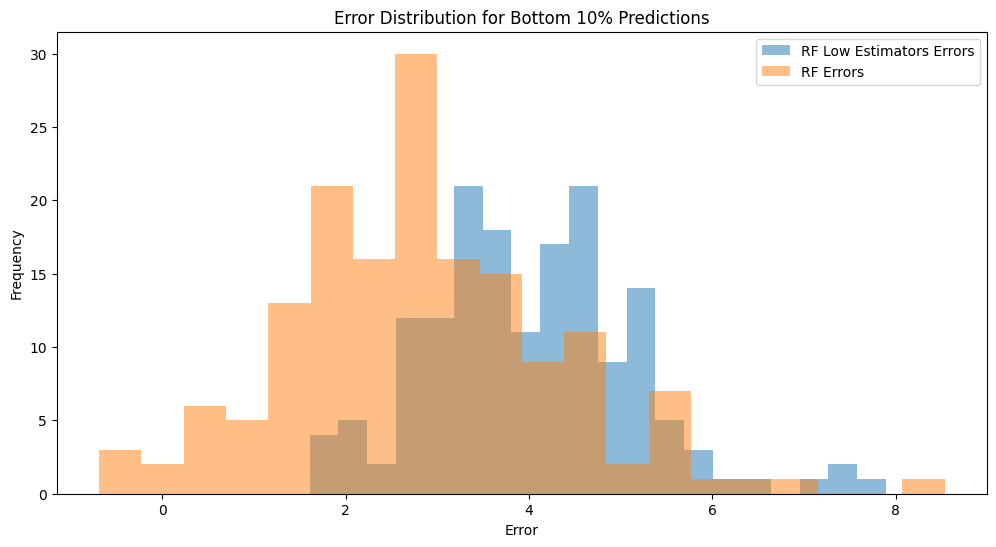

In [ ]:
# Error distributions
errors_low_rf = pred_low_rf_bottom_10 - actual_values_bottom_10
errors_rf = pred_rf_bottom_10 - actual_values_bottom_10

# Plot error distribution
plt.figure(figsize=(12, 6))
plt.hist(errors_low_rf, bins=20, alpha=0.5, label='RF Low Estimators Errors')
plt.hist(errors_rf, bins=20, alpha=0.5, label='RF Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Distribution for Bottom 10% Predictions')
plt.show()


In [ ]:
### Statistical Significance: T-Test Between Errors of Two Models
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(errors_low_rf, errors_rf, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of the P-value
if p_value < 0.05:
    print("There is a statistically significant difference between the models' errors for the bottom 10% of target values.")
else:
    print("There is no statistically significant difference between the models' errors for the bottom 10% of target values.")

T-statistic: 8.086896874767321, P-value: 1.540960181455718e-14
There is a statistically significant difference between the models' errors for the bottom 10% of target values.


### Random Selection

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Generate random predictions from the entire range of actual target values
random_preds = np.random.choice(actual_values_unstd.flatten(), size=len(actual_values_bottom_10))

# Calculate MAE and RMSE for these random predictions against the actual bottom 10% values
mae_random = mean_absolute_error(actual_values_bottom_10, random_preds)
rmse_random = mean_squared_error(actual_values_bottom_10, random_preds, squared=False)

print("Random Selection - MAE for bottom 10% predictions:", mae_random)
print("Random Selection - RMSE for bottom 10% predictions:", rmse_random)


Random Selection - MAE for bottom 10% predictions: 4.2523125
Random Selection - RMSE for bottom 10% predictions: 4.738065995213659


/home/juan/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
